In [2]:
from __future__ import print_function
__author__ = "zeshi"

import numpy as np
from scipy.linalg import svd
import scipy
import math
from mysqldb_level_0 import query_data_level0, site_info_check
from level0_2_level1 import query_data_level1
import mysql.connector
from mysql.connector import errorcode
from datetime import datetime, date, timedelta
import pandas as pd

__This function should be runned every year before the snow season to figure out the baseline of the snow-depth data__
```
WY: Water year
```

In [3]:
def snowdepth_baseline_update(WY):
    all_motes_query = ("SELECT site_id, node_id FROM motes")
    site_name_query = ("SELECT site_name FROM sites WHERE site_id = %s")
    baseline_update = ("UPDATE motes SET ground_dist = %s WHERE site_id = %s AND node_id = %s")
    # old_baseline_query = ("SELECT ground_dist FROM motes WHERE site_id = %s AND node_id = %s")
    min_datetime = datetime(WY-1, 8, 1)
    max_datetime = datetime(WY-1, 10, 1)
    cnx = mysql.connector.connect(user='root', password='root', database='ar_data') 
    cursor = cnx.cursor()
    try:
        cursor.execute(all_motes_query)
    except mysql.connector.Error as err:
        print("Query motes problem")
        print(err)
    all_motes = cursor.fetchall()
    for mote in all_motes:
        mote_ground_distance = query_data_level1(mote[0], mote[1], min_datetime, max_datetime, field='snowdepth')
        mote_ground_distance = np.array([i[0] for i in mote_ground_distance])
        mote_ground_distance = mote_ground_distance[mote_ground_distance >= 2000.]
        ground_distance = np.nanmean(mote_ground_distance)
        if mote_ground_distance.size == 0:
            ground_distance = None
            print("site_id:" + str(mote[0]) + " node_id:" + str(mote[1]) + " no record for WY:" + str(WY))
        if ground_distance is not None:
            try:
                cursor.execute(baseline_update, (float(ground_distance), mote[0], mote[1]))
            except mysql.connector.Error as err:
                print(err)
            print("site_id:" + str(mote[0]) + " node_id:" + str(mote[1]) + " baseline update complete!")
    cnx.commit()
    cursor.close()
    cnx.close()

In [4]:
def pd_query(site_name_id, node_id, starting_time, ending_time):
    site_id = site_info_check(site_name_id, node_id)
    sql_query = "SELECT * FROM level_1 WHERE site_id = " + str(site_id) + " AND node_id = " + str(node_id) + \
                     " AND datetime >= '" + starting_time.strftime("%Y-%m-%d %H:%M:%S") + "' AND datetime <= '" + \
                     ending_time.strftime("%Y-%m-%d %H:%M:%S") + "'"
    cnx = mysql.connector.connect(user = "root", password = "root", database = "ar_data")
    try:
        pd_table = pd.read_sql_query(sql_query, cnx)
    except Exception as err:
        print(err)
        print("Querying error happens between pandas and mysql when getting level_1 data.")
    cnx.close()
    return pd_table

In [5]:
def pd_query_ground_dist(site_name_id, node_id):
    site_id = site_info_check(site_name_id, node_id)
    sql_query = "SELECT ground_dist FROM motes WHERE site_id = " + str(site_id) + " AND node_id = " + str(node_id)
    cnx = mysql.connector.connect(user = "root", password = "root", database = "ar_data")
    try:
        ground_dist = pd.read_sql_query(sql_query, cnx)
    except Exception as err:
        print(err)
        print("Queryiing error happens between pandas and mysql when getting ground_dist from TABLE motes.")
    cnx.close()
    return ground_dist

The function will run by node, however, it is better to group 

In [6]:
def level1_cleaning_node_query(site_name_id, node_id, starting_time, ending_time):
    dirty_table = pd_query(site_name_id, node_id, starting_time, ending_time)
    ground_dist = pd_query_ground_dist(site_name_id, node_id).as_matrix()[0, 0]
    dirty_sd = np.array(dirty_table['snowdepth'].as_matrix(), dtype=np.float)
    dirty_temp = np.array(dirty_table['temperature'].as_matrix(), dtype = np.float)
    dirty_rh = np.array(dirty_table['relative_humidity'].as_matrix(), dtype = np.float)
    return (dirty_sd, dirty_temp, dirty_rh)

In [7]:
def pca(data, d):
    temp_data = np.copy(data)
    temp_data = temp_data
    U, S, V = svd(temp_data, full_matrices=False)
    U = U[:, :d]
    U *= S[:d] ** 0.5
    return U

In [8]:
def pca_clean(data_matrix, d):
    temp_data_matrix = np.copy(data_matrix)
    for i in range(0, temp_data_matrix.shape[1]):
        temp_data_matrix[np.isnan(temp_data_matrix[:, i]), i] = np.nanmean(temp_data_matrix[:, i])
    s_mode_U = np.matrix(pca(temp_data_matrix, d))
    t_mode_U = np.matrix(pca(temp_data_matrix.T, d))
    reconstruction = s_mode_U * t_mode_U.T
    return reconstruction

In [9]:
def dineof(input_data, n_max = None, max_Iter = 100, rms_inc = 1e-5):
    data = np.copy(input_data)
    if n_max is None:
        n_max = data.shape[1]
    is_nan = np.isnan(data)
    not_nan = np.isfinite(data)
    recon = np.array(pca_clean(data, n_max))
    rms_prev = float('Inf')
    rms_now = np.sqrt(np.sum(np.square((recon[not_nan] - data[not_nan]))))
    data[is_nan] = recon[is_nan]
    iteration = 1
    while ((rms_prev - rms_now) > rms_inc) and iteration <= max_Iter:
        iteration += 1
        recon = np.array(pca_clean(data, n_max))
        rms_temp = np.sqrt(np.sum(np.square((recon[not_nan] - data[not_nan]))))
        if rms_temp < rms_now:
            rms_prev = np.copy(rms_now)
            rms_now = np.copy(rms_temp)
        data[is_nan] = recon[is_nan]
    return data

In [10]:
class CollaborativeFiltering:
    def __init__(self, R, r, tol = 1e-2, maxIter = 1000, l = 1e-3, mu = 1e-3):
        self.R = R
        self.r = r
        self.tol = tol
        self.maxIter = maxIter
        self.l = l
        self.mu = mu
        self.numUser = R.shape[0]
        self.numItem = R.shape[1]
        ## u should be number of users * r
        self.u = np.random.randn(R.shape[0], r) * math.sqrt(10)
        ## u should be number of r * number of itemss
        self.v = np.random.randn(r, R.shape[1]) * math.sqrt(10)
        self.Iter = 0
        self.loss = float('inf')
        
    def train(self):
        new_u = self.updateU(self.v)
        new_v = self.updateV(new_u)
        i = 1.
        while (np.linalg.norm(self.u - new_u) > self.tol or 
               np.linalg.norm(self.v - new_v) > self.tol) and self.Iter < self.maxIter:
            self.l = 1./i
            self.mu = 1./i
            i += 1.
            self.Iter += 1
            self.u = new_u
            self.v = new_v
            new_u = self.updateU(new_v)
            new_v = self.updateV(new_u)
            
    def calculateLoss(self):
        self.loss = np.linalg.norm(np.nan_to_num(np.dot(self.u, self.v) - self.R)) + \
                    self.l * np.linalg.norm(self.u) + \
                    self.mu * np.linalg.norm(self.v)
    
    def updateU(self, v):
        new_u = np.zeros((self.numUser, self.r))
        for i in range(self.numUser):
            ## get the index of non nan v index:
            v_indexes = np.isfinite(self.R[i, :])
            v_v_indexes = v[:, v_indexes]
            R_v_indexes = self.R[i, v_indexes]
            ## update u[i]
            u_i = np.linalg.solve(np.dot(v_v_indexes, v_v_indexes.T) + self.l * np.eye(self.r), 
                                  np.dot(v_v_indexes, R_v_indexes.T)).T
            new_u[i] = u_i
        return new_u
    
    def updateV(self, u):
        new_v = np.zeros((self.r, self.numItem))
        for i in range(self.numItem):
            ## get the index of non nan v index:
            u_indexes = np.isfinite(self.R[:, i])
            u_u_indexes = u[u_indexes, :]
            R_u_indexes = self.R[u_indexes, i]
            ## update u[i]
            v_i = np.linalg.solve(np.dot(u_u_indexes.T, u_u_indexes) + self.mu * np.eye(self.r), 
                                  np.dot(u_u_indexes.T, R_u_indexes))
            new_v[:,i] = v_i
        return new_v

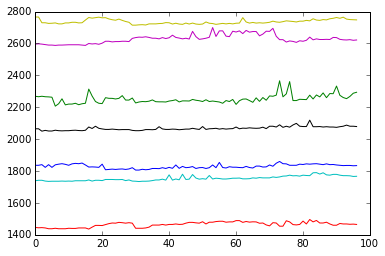

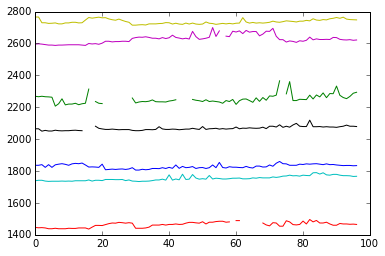

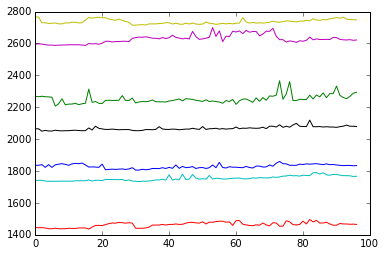

In [15]:
cf = CollaborativeFiltering(dirty_sd, 2, maxIter=100, l=1e-1, mu=1e-1)
cf.train()
u = cf.u
v = cf.v
recon = np.dot(u, v)
clean_sd = np.copy(dirty_sd)
clean_sd[np.isnan(clean_sd)] = recon[np.isnan(clean_sd)]
from matplotlib import pyplot as plt
%matplotlib inline
for i in range(0, clean_sd.shape[1]):
    plt.plot(range(0, len(clean_sd)), clean_sd[:, i])
plt.show()
for i in range(0, dirty_sd.shape[1]):
    plt.plot(range(0, len(dirty_sd)), dirty_sd[:, i])
plt.show()
another_clean = dineof(dirty_sd, 2)
for i in range(0, another_clean.shape[1]):
    plt.plot(range(0, len(another_clean)), another_clean[:, i])
plt.show()

In [11]:
def level1_cleaning_site_pca_clean(site_name_id, site_num_of_nodes, starting_time, ending_time):
    retained_list = []
    sd_matrix = None
    temp_matrix = None
    rh_matrix = None
    for temp_node_id in range(1, site_num_of_nodes + 1):
        (temp_dirty_sd, temp_dirty_temp, temp_dirty_rh) = level1_cleaning_node_query(site_name_id, 
                                                                                     temp_node_id, 
                                                                                     starting_time, 
                                                                                     ending_time)
        temp_data_length = len(temp_dirty_sd)
        # Clean temperature, rh. And clean the snow depth for the first round
        temp_dirty_temp[np.logical_or(temp_dirty_temp >= 100., temp_dirty_temp <= -30.)] = np.nan
        temp_dirty_rh[np.logical_or(temp_dirty_rh >= 100., temp_dirty_rh <= 0.)] = np.nan
        temp_dirty_sd[np.logical_or(temp_dirty_sd >= 5000., temp_dirty_sd <= 600.)] = np.nan
        last_not_nan = None
        last_not_nan_idx = None
        # Clean snow depth data one by one
        for i in range(0, temp_data_length):
            if not np.isnan(temp_dirty_sd[i]):
                if last_not_nan is not None:
                    if abs(temp_dirty_sd[i] - last_not_nan) >= 100 and (i - last_not_nan_idx) <= 10:
                        temp_dirty_sd[i] = np.nan
                    if abs(temp_dirty_sd[i] - last_not_nan) >= 400 and (i - last_not_nan_idx) <= 100:
                        temp_dirty_sd[i] = np.nan
                else:
                    last_not_nan = temp_dirty_sd[i]
                    last_not_nan_idx = i
        temp_data_not_nan = len(np.where(~np.isnan(temp_dirty_sd))[0])
        if temp_data_not_nan < 0.5 * float(temp_data_length) or temp_data_length == 0:
            continue
        retained_list.append(temp_node_id)
        if sd_matrix is None:
            sd_matrix = temp_dirty_sd
            temp_matrix = temp_dirty_temp
            rh_matrix = temp_dirty_rh
        else:
            sd_matrix = np.column_stack((sd_matrix, temp_dirty_sd))
            temp_matrix = np.column_stack((temp_matrix, temp_dirty_temp))
            rh_matrix = np.column_stack((rh_matrix, temp_dirty_rh))
    if len(retained_list) == 0 or len(retained_list) == 1:
        return (None, None, None, None)
    if sd_matrix.shape[1] >= 5:
        num_pc = sd_matrix.shape[1]
    else:
        num_pc = 2
    original_sd = np.copy(sd_matrix)
    sd_recon = dineof(sd_matrix, n_max=num_pc)
    sd_matrix[np.isnan(sd_matrix)] = sd_recon[np.isnan(sd_matrix)]
    temp_recon = dineof(temp_matrix, n_max=num_pc)
    temp_matrix[np.isnan(temp_matrix)] = temp_recon[np.isnan(temp_matrix)]
    rh_recon = dineof(rh_matrix, n_max=num_pc)
    rh_matrix[np.isnan(rh_matrix)] = rh_recon[np.isnan(rh_matrix)]
#     return (retained_list, sd_matrix, temp_matrix, rh_matrix)
    return(sd_matrix, original_sd)

In [12]:
def level1_cleaning_site_clean_update(site_id, retained_list, datetime_list, sd_clean, temp_clean, rh_clean):
    update_string = ("UPDATE level_1 SET sd_clean = %s, tmp_clean = %s, rh_clean = %s WHERE site_id = %s " 
                     "AND node_id = %s AND datetime = %s")
    update_data = ()
    for i, node_id in enumerate(retained_list):
        for j, temp_datetime in enumerate(datetime_list):
            update_data += ((float(sd_clean[j, i]), float(temp_clean[j, i]), float(rh_clean[j, i]), 
                             int(site_id), int(node_id), temp_datetime),)
    cnx = mysql.connector.connect(user = "root", password = "root", database = "ar_data")
    cursor = cnx.cursor()
    try:
        cursor.executemany(update_string, update_data)
        cnx.commit()
    except mysql.connector.Error as err:
        print(err)
        print("Problems when updating cleaned data")
    cursor.close()
    cnx.close()
    return

# Cleaning should be done daily!!!

In [13]:
def level1_cleaning_site(site_name_id, starting_time, ending_time):
    if isinstance(site_name_id, str):
        query_string = ("SELECT site_id, num_of_nodes FROM sites WHERE site_name = '" + site_name_id + "'")
        
    else:
        query_string = ("SELECT site_id, num_of_nodes FROM sites WHERE site_id = " + str(site_name_id))
    cnx = mysql.connector.connect(user = "root", password = "root", database = "ar_data")
    try:
        site_info = pd.read_sql_query(query_string, cnx)
    except Exception as err:
        print(err)
        print("Querying site info error")
    cnx.close()
    site_id = site_info["site_id"].as_matrix()[0]
    site_num_of_nodes = site_info["num_of_nodes"].as_matrix()[0]
    retained_list, sd_clean, temp_clean, rh_clean = level1_cleaning_site_pca_clean(site_name_id, 
                                                                                   site_num_of_nodes,
                                                                                   starting_time,
                                                                                   ending_time)
    if retained_list is not None:
        datetime_list = []
        temp_datetime = starting_time
        while temp_datetime <= ending_time:
            datetime_list.append(temp_datetime)
            temp_datetime += timedelta(minutes=15)
        level1_cleaning_site_clean_update(site_id, retained_list, datetime_list, sd_clean, temp_clean, rh_clean)
    return

In [14]:
# sd, temp, rh = level1_cleaning_node_query("Duncan_Pk", 6, datetime(2016, 1, 25), datetime(2016, 2, 1))
# print (np.where(~np.isnan(sd)))
# print(len(np.where(~np.isnan(sd))[0]))
# a = np.array([1,2,3,np.nan,4,5,101])
# print(a)
# a[a>100] = np.nan
# print(a)
# print(np.isnan(np.nan))
# level1_cleaning_site_pca_clean("Duncan_Pk", 11, datetime(2016, 1, 25), datetime(2016, 2, 1))
clean_sd, dirty_sd = level1_cleaning_site_pca_clean("Duncan_Pk", 11, datetime(2016, 1, 25), datetime(2016, 1, 26))

In [ ]:
print(dirty_sd, clean_sd)